In [75]:
# from nltk.corpus import stopwords
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

string = 'I am a cat. As yet I have no name.'
# 各単語のリストを作ってくれる
words = nltk.word_tokenize(string)

print(words)

# 各単語にタグを付けている
tags = nltk.pos_tag(words)

print(tags)

['I', 'am', 'a', 'cat', '.', 'As', 'yet', 'I', 'have', 'no', 'name', '.']
[('I', 'PRP'), ('am', 'VBP'), ('a', 'DT'), ('cat', 'NN'), ('.', '.'), ('As', 'IN'), ('yet', 'RB'), ('I', 'PRP'), ('have', 'VBP'), ('no', 'DT'), ('name', 'NN'), ('.', '.')]


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import string
from spellchecker import SpellChecker

tweet = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/train.csv')

In [77]:
# 各タグの説明
import nltk
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [78]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 7613 rows and 5 columns in train


Text(0, 0.5, 'samples')

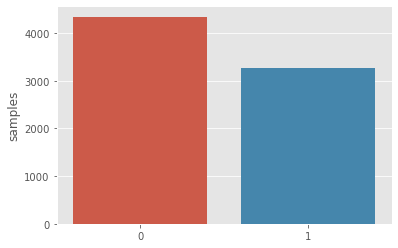

In [79]:
# まずは1と0が何個ずつあるか見る

x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

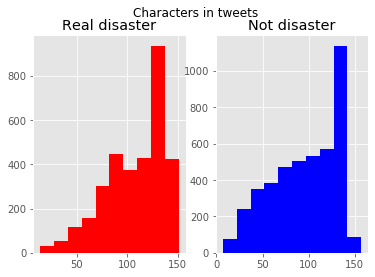

In [80]:
# Real disasterに関するtweetとそうではないtweetの文字数はどんなもんか見てみる

fig, axes = plt.subplots(1, 2)
tweet_len = tweet[tweet['target']==1]['text'].str.len()
axes[0].hist(tweet_len, color='r')
axes[0].set_title('Real disaster')
tweet_len = tweet[tweet['target'] == 0]['text'].str.len()
axes[1].hist(tweet_len, color='b')
axes[1].set_title('Not disaster')
fig.suptitle('Characters in tweets')
plt.show()

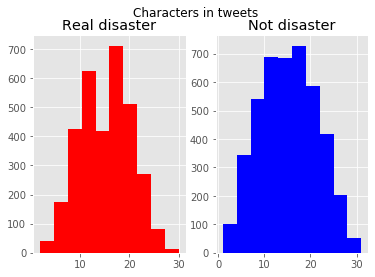

In [81]:
# 単語数は?

fig, axes = plt.subplots(1, 2)
tweet_len = tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
axes[0].hist(tweet_len, color='r')
axes[0].set_title('Real disaster')
tweet_len = tweet[tweet['target'] == 0]['text'].str.split().map(lambda x: len(x))
axes[1].hist(tweet_len, color='b')
axes[1].set_title('Not disaster')
fig.suptitle('Characters in tweets')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

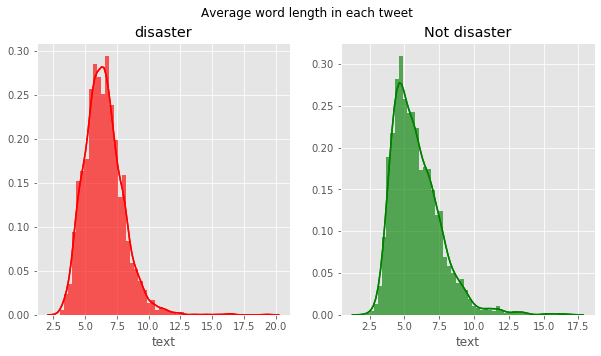

In [82]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [83]:
tweet[tweet['target']==0]['text'].str.split()

15                                     [What's, up, man?]
16                                      [I, love, fruits]
17                                   [Summer, is, lovely]
18                                [My, car, is, so, fast]
19                       [What, a, goooooooaaaaaal!!!!!!]
                              ...                        
7581    [@engineshed, Great, atmosphere, at, the, Brit...
7582    [Cramer:, Iger's, 3, words, that, wrecked, Dis...
7584    [These, boxes, are, ready, to, explode!, Explo...
7587                                [Sirens, everywhere!]
7593    [I, just, heard, a, really, loud, bang, and, e...
Name: text, Length: 4342, dtype: object

In [84]:
def create_corpus(target):   
    corpus = []
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [85]:
corpus=create_corpus(0)

dic=defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
    else:
        dic[word] = 1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

<BarContainer object of 10 artists>

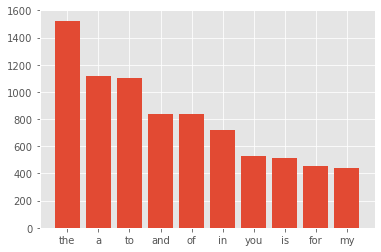

In [86]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

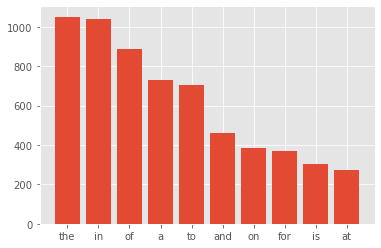

In [87]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)


<BarContainer object of 18 artists>

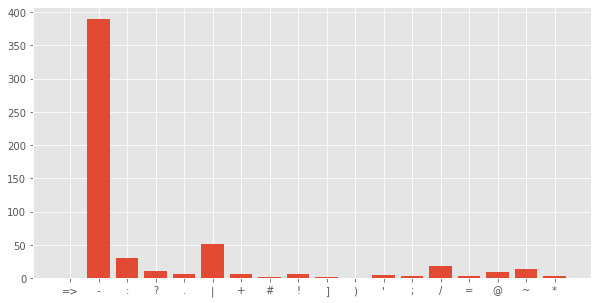

In [88]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)

special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

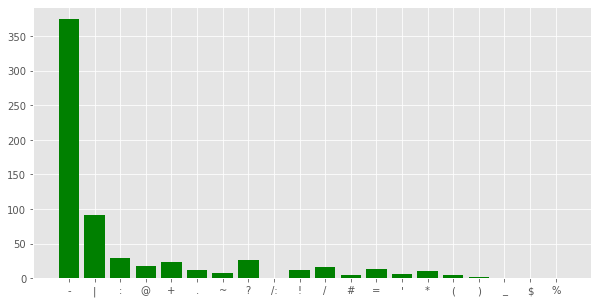

In [89]:
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)

special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [90]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

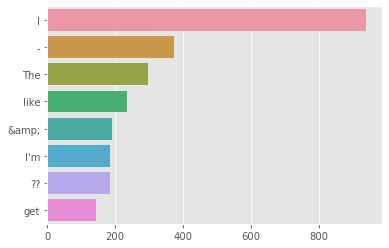

In [91]:
sns.barplot(x=y,y=x)

In [92]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

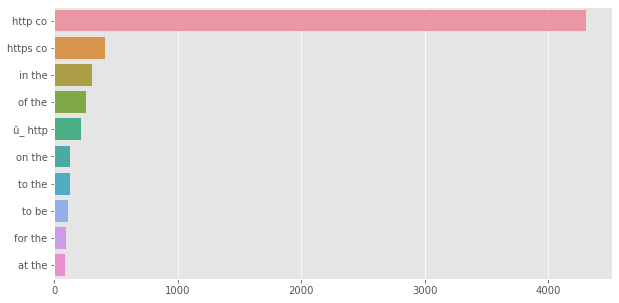

In [93]:
plt.figure(figsize=(10,5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x,y = map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

# Data cleaning

In [94]:
print(tweet.shape)
print(test.shape)
df=pd.concat([tweet,test])
df.shape

(7613, 5)
(7613, 5)


(15226, 5)

In [95]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [96]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [97]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [98]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# remove_emoji("Omg another Earthquake 😔😔")
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [99]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text'] = df['text'].apply(lambda x : remove_punct(x))

In [100]:
# 重くて最後まで回らない

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    temp = text.split()
    misspelled_words = spell.unknown(temp)
    print(misspelled_words)
    for word in temp:
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

df['text'] = df['text'].apply(lambda x : correct_spellings(x))

set()
{'ronge', 'sask'}
set()
{'wildfires'}
{'wildfires'}
{'cafire', 'hwy', 'rockyfire', 'wildfires'}
set()
set()
set()
set()
set()
{'fvck', 'haha'}
{'tampabay'}
{'bago'}
set()
set()
set()
set()
set()
{'goooooooaaaaaal'}
set()
set()
set()
set()
{'looooool'}
{'wayi'}
{'nyc'}
set()
{'cooool'}
set()
set()
{'bbcmtd'}
set()
{'newsnigeria', 'africanbaze'}
set()
set()
{'phdsquares', 'theyve'}
{'abia', 'inec'}
{'\x89ûó', '\x89ûò', 'superintende'}
set()
{'nsfw'}
{'youre'}
{'ancop'}
{'southridgelife', 'soooo'}
set()
set()
{'wildfires'}
{'tracklist'}
{'nsfw'}
set()
set()
set()
{'\x89ûó', 'lanford'}
{'carolinaåêablaze'}
{'noches', 'alexissanchez', 'elbestia'}
{'diyala'}
{'voortrekker', 'intl'}
{'\x89û'}
set()
{'wildfires'}
{'wmv', 'gtxrwm', 'dvd'}
set()
{'jacinta', '2k13'}
{'navista7', 'news24680'}
{'nowplaying', 'edm'}
{'nxwestmidlands'}


KeyboardInterrupt: 

In [112]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus = create_corpus(df)

100%|██████████| 15226/15226 [00:01<00:00, 9063.05it/s]


In [113]:
for i in range(10000):
    print(corpus[i])

 'confirmed', 'relatives', 'hope', 'discovery', 'crash', 'site', 'malaysian', 'officials', 'confirm', 'breakth']
['abc', 'aircraft', 'debris', 'found', 'la', 'reunion', 'missing', 'malaysia', 'airlines', 'abc', 'onlinea', 'piece', 'aircraft', 'debris']
['malaysia', 'confirms', 'reunion', 'island', 'debris', 'scmpnews']
['debris', 'confirmed', 'relatives', 'hope', 'discovery', 'crash', 'site', 'via', 'reuters', 'video']
['plane', 'debris', 'missing']
['aircraft', 'debris', 'found', 'la', 'reunion', 'missing', 'malaysia', 'airlines', 'abc', 'onlin', 'g', 'malaysia', 'news']
['interesting', 'aircraft', 'debris', 'found', 'la', 'reunion', 'missing', 'malaysia', 'airlines', 'abc', 'please', 'rt']
['aircraft', 'debris', 'confirmed', 'nation', 'the', 'star', 'online']
['dustpiggies', 'ah', 'i', 'awash', 'abstract', 'dustpig', 'tweets', 'explains', 'deluge']
['xeni', 'bet', 'mother', 'nature', 'might', 'plans', 'send', 'deluge', 'way']
['joshsternberg', 'my', 'feed', 'seems', 'deluge', 'twice'

In [114]:
import os
cwd = os.getcwd()

embedding_dict={}

with open('..\\..\\glove.6B\\glove.6B.100d.txt','r',encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

[truncateとは](https://keras.io/ja/preprocessing/sequence/https://keras.io/ja/preprocessing/sequence/)
[tokenizerについて](https://qiita.com/tomiyou/items/da0b4cc85b89eb0b6d1dhttps://qiita.com/tomiyou/items/da0b4cc85b89eb0b6d1d)

In [115]:
MAX_LEN = 50
tokenizer_obj = Tokenizer() # kerasのクラス
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [116]:
for i in range(10000):
    print(corpus[i])

 'confirmed', 'relatives', 'hope', 'discovery', 'crash', 'site', 'malaysian', 'officials', 'confirm', 'breakth']
['abc', 'aircraft', 'debris', 'found', 'la', 'reunion', 'missing', 'malaysia', 'airlines', 'abc', 'onlinea', 'piece', 'aircraft', 'debris']
['malaysia', 'confirms', 'reunion', 'island', 'debris', 'scmpnews']
['debris', 'confirmed', 'relatives', 'hope', 'discovery', 'crash', 'site', 'via', 'reuters', 'video']
['plane', 'debris', 'missing']
['aircraft', 'debris', 'found', 'la', 'reunion', 'missing', 'malaysia', 'airlines', 'abc', 'onlin', 'g', 'malaysia', 'news']
['interesting', 'aircraft', 'debris', 'found', 'la', 'reunion', 'missing', 'malaysia', 'airlines', 'abc', 'please', 'rt']
['aircraft', 'debris', 'confirmed', 'nation', 'the', 'star', 'online']
['dustpiggies', 'ah', 'i', 'awash', 'abstract', 'dustpig', 'tweets', 'explains', 'deluge']
['xeni', 'bet', 'mother', 'nature', 'might', 'plans', 'send', 'deluge', 'way']
['joshsternberg', 'my', 'feed', 'seems', 'deluge', 'twice'

In [117]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 16230


In [118]:
print(word_index)

83, 'ava': 15184, 'sparxxx': 15185, 'threesome': 15186, 'stretches': 15187, 'victorian': 15188, 'sofa': 15189, 'reference': 15190, 'heller': 15191, 'marley': 15192, 'brinx': 15193, 'striptease': 15194, 'spreads': 15195, 'pounding': 15196, 'rotation': 15197, 'condenses': 15198, 'villa': 15199, 'mcv': 15200, 'subtornado': 15201, 'ayshuntornado': 15202, 'giselle': 15203, 'toocodtodd': 15204, 'tulowitzki': 15205, 'hayden': 15206, 'poses': 15207, 'strips': 15208, 'timesofindia': 15209, 'soulja': 15210, 'maaaaan': 15211, 'greater': 15212, 'comfortable': 15213, 'sorrowful': 15214, 'redemption': 15215, 'platt': 15216, 'homeworldgym': 15217, 'thisisperidot': 15218, 'monicas': 15219, 'wm': 15220, 'lewis': 15221, 'toiindianews': 15222, 'ofcourse': 15223, 'caued': 15224, 'washing': 15225, 'tanehisicoates': 15226, 'laced': 15227, 'monologue': 15228, 'charlize': 15229, 'coulda': 15230, 'tbr': 15231, 'browsing': 15232, 'gr': 15233, 'homepage': 15234, 'sriramk': 15235, 'commons': 15236, 'ownership': 1

[dict.get()](https://www.tutorialspoint.com/python/dictionary_get.htmhttps://www.tutorialspoint.com/python/dictionary_get.htm)

In [119]:
# word_indexの辞書のキーと値を入れ替えてる

num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words: # What is this statement for?
        continue
    
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|██████████| 16230/16230 [00:00<00:00, 601085.68it/s]


In [120]:
model = Sequential()

embedding = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer = Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [121]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1623100   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,665,405
Trainable params: 42,305
Non-trainable params: 1,623,100
_________________________________________________________________


In [126]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]]

In [127]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [128]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 20s - loss: 0.6912 - accuracy: 0.5682 - val_loss: 0.6874 - val_accuracy: 0.5788
Epoch 2/15
 - 19s - loss: 0.6511 - accuracy: 0.6277 - val_loss: 0.5682 - val_accuracy: 0.7723
Epoch 3/15
 - 20s - loss: 0.5866 - accuracy: 0.7296 - val_loss: 0.5177 - val_accuracy: 0.7741
Epoch 4/15
 - 26s - loss: 0.5689 - accuracy: 0.7381 - val_loss: 0.5045 - val_accuracy: 0.7758
Epoch 5/15
 - 26s - loss: 0.5611 - accuracy: 0.7385 - val_loss: 0.4992 - val_accuracy: 0.7811
Epoch 6/15
 - 26s - loss: 0.5496 - accuracy: 0.7510 - val_loss: 0.4947 - val_accuracy: 0.7811
Epoch 7/15
 - 28s - loss: 0.5460 - accuracy: 0.7510 - val_loss: 0.4928 - val_accuracy: 0.7767
Epoch 8/15
 - 28s - loss: 0.5369 - accuracy: 0.7636 - val_loss: 0.4897 - val_accuracy: 0.7890
Epoch 9/15
 - 29s - loss: 0.5421 - accuracy: 0.7529 - val_loss: 0.4883 - val_accuracy: 0.7881
Epoch 10/15
 - 28s - loss: 0.5413 - accuracy: 0.7575 - val_loss: 0.4868 - val_accuracy: 0.7881
Epoch 11/15